Importing Tensorflow

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# To run only on CPU:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
MODEL = "MobileNet" # VGG16, VGG19, InceptionV3, Xception, ResNet50, MobileNet
HARD = True


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

print("Successfully imported libraries.")

Successfully imported libraries.


Getting Data

In [18]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# Get this dataset
data_dir = pathlib.Path(F"./Dataset{'-Hard' if HARD else ''}") # -Hard

image_count = len(list(data_dir.glob("*/*.jp*g")))
print("Images available to use: " + str(image_count))

GPUs Available:  []
Images available to use: 977


In [19]:
# Put into an image dataset.

batch_size = 64
img_height = 224
img_width = 224
channels = 3
preprocess = tf.keras.applications.imagenet_utils.preprocess_input

if MODEL in ("InceptionV3", "Xception"):
    # Image size should be (299, 299)
    img_height = 299
    img_width = 299

if MODEL == "InceptionV3":
    # Use different preprocessing function
    preprocess = tf.keras.applications.inception_v3.preprocess_input
if MODEL == "Xception":
    # Use different preprocessing function
    preprocess = tf.keras.applications.xception.preprocess_input
if MODEL == "MobileNet":
    preprocess = tf.keras.applications.mobilenet.preprocess_input
if MODEL == "ResNet50":
    preprocess = tf.keras.applications.resnet50.preprocess_input

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    color_mode=("grayscale" if channels == 1 else "rgb"),
    seed=1314,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=314,
    color_mode=("grayscale" if channels == 1 else "rgb"),
    image_size=(img_height,img_width),
    batch_size=batch_size
)

# Apply preprocessing:
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)

print(F"Using classes: {', '.join(class_names)}")
print(F"Image shape: ({img_width}, {img_height}, {channels})")

Found 978 files belonging to 2 classes.
Using 881 files for training.
Found 978 files belonging to 2 classes.
Using 97 files for validation.
Using classes: Guns, No Guns
Image shape: (224, 224, 3)


Visualizing Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

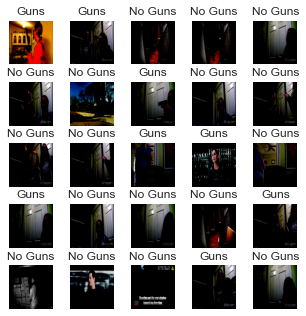

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(5, 5))

for images, labels in train_ds.take(1):
    for i in range(25):
        ax = fig.add_subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy()) # .astype("uint8")
        ax.set_title(class_names[labels[i]], fontsize=12)
        plt.axis("off")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.savefig(F"{MODEL}_Info/sample_img_{MODEL}.jpg")
plt.show()

Performance Tuning

In [21]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the Model!

In [22]:
num_classes = len(class_names)

map_model = {
    "InceptionV3": tf.keras.applications.InceptionV3,
    "VGG16": tf.keras.applications.VGG16,
    "VGG19": tf.keras.applications.VGG19,
    "Xception": tf.keras.applications.Xception,
    "MobileNetV3Large": tf.keras.applications.MobileNetV3Large,
    "MobileNet": tf.keras.applications.MobileNet,
    "ResNet50": tf.keras.applications.ResNet50
}

model = map_model[MODEL](include_top=True, weights=None, classes=num_classes, input_shape=(img_width, img_height, 3))

tf.keras.utils.plot_model(model, to_file=F"{MODEL}_Info/{MODEL}-Structure-Concat.png")
fh = open(F"{MODEL}_Info/{MODEL}-Summary.txt", "w")
model.summary(print_fn=lambda x: fh.write(x + '\n'))

model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [23]:
# Compile model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy", "mse"])

# Save model here every 100 batches
checkpoint_path = F"{MODEL}_weights/{MODEL}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor="val_accuracy",
                                                 model="max",
                                                 save_freq='epoch',
                                                 save_best_only=True)


# Get last model saved
model.load_weights(checkpoint_path)
print(F"Restored weights from {checkpoint_path}")

Restored weights from MobileNet_weights/MobileNet.ckpt


In [24]:
# Start training!
import csv
import tensorflow.keras.backend as K

# On end of batch, save model history into .csv; allows us to train multiple times over while retaining and being able to graph history.
class StoreModelHistory(keras.callbacks.Callback):
  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    # if not (F'{MODEL}_Info/model_history_{MODEL}.csv' in os.listdir("./")):
    #   with open(F'{MODEL}_Info/model_history_{MODEL}.csv','w') as f:
    #     y=csv.DictWriter(f,logs.keys())
    #     y.writeheader()

    with open(F'./{MODEL}_Info/model_history_{MODEL}.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[cp_callback, StoreModelHistory()]
)

Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 0.8953 - accuracy: 0.7378 - mse: 0.4035
Epoch 00001: val_accuracy improved from -inf to 0.75258, saving model to MobileNet_weights\MobileNet.ckpt
14/14 [==============================] - 37s 2s/step - loss: 0.8953 - accuracy: 0.7378 - mse: 0.4035 - val_loss: 0.5048 - val_accuracy: 0.7526 - val_mse: 0.3396 - lr: 0.0100
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8490 - mse: 0.3532
Epoch 00002: val_accuracy did not improve from 0.75258
14/14 [==============================] - 35s 3s/step - loss: 0.3410 - accuracy: 0.8490 - mse: 0.3532 - val_loss: 2.1478 - val_accuracy: 0.6082 - val_mse: 0.4692 - lr: 0.0100
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9512 - mse: 0.4440
Epoch 00003: val_accuracy improved from 0.75258 to 0.77320, saving model to MobileNet_weights\MobileNet.ckpt
14/14 [==============================] - 35s 3s/step - los

KeyboardInterrupt: 

In [25]:
model.load_weights(checkpoint_path)


Analyze Results

In [26]:
# Read file containing info
info = np.genfromtxt(F'{MODEL}_Info/model_history_{MODEL}.csv', dtype=np.float32, delimiter=",")

# loss,accuracy,mse,val_loss,val_accuracy,val_mse,lr
acc = info[:,1]
val_acc = info[:,4]

loss = info[:,0]
val_loss = info[:,3]

mse = info[:,2]
val_mse = info[:,-2]

epochs_range = range(len(info))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(F'{MODEL}{" - Hard Dataset" if HARD else ""}: Training and Validation Accuracy')
plt.savefig(F"{MODEL}_Info/{MODEL}{'_Hard' if HARD else ''}_accuracy.png")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(F'{MODEL}{" - Hard Dataset" if HARD else ""}: Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(F"{MODEL}_Info/{MODEL}_loss.png")
plt.show()

plt.plot(epochs_range, loss, label='Training MSE')
plt.plot(epochs_range, val_loss, label='Validation MSE')
plt.legend(loc='upper right')
plt.title(F'{MODEL}{" - Hard Dataset" if HARD else ""}: Mean Squared Error')
plt.savefig(F"{MODEL}_Info/{MODEL}_MSE.png")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

ValueError: Some errors were detected !
    Line #22 (got 13 columns instead of 7)

In [27]:
import sklearn.metrics as metrics
import seaborn as sns
sns.set_theme()

def print_results(y_test, y_pred):
    # Show the test data's result
    print("Set results:")
    print("------------------------------------------------")
    # y_test = y_test.argmax(axis=1)
    # y_pred = y_pred.argmax(axis=1)
    print(metrics.confusion_matrix(y_test, y_pred))
    print('kappa:       ', metrics.cohen_kappa_score(y_test, y_pred))
    print('accuracy:    ', metrics.accuracy_score(y_test, y_pred))
    print('recall:      ', metrics.recall_score(y_test, y_pred, average=None))
    print('precision:   ', metrics.precision_score(y_test, y_pred, average=None))
    print('f_1:         ', metrics.f1_score(y_test, y_pred, average=None))


In [28]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path("./Dataset"),
    validation_split=0.2,
    subset="validation",
    color_mode=("grayscale" if channels == 1 else "rgb"),
    seed=1314,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
predictions = model.predict(test_ds)
print(predictions)

values = np.concatenate(list(test_ds.map(lambda x,y: y).as_numpy_iterator()))

Found 15076 files belonging to 2 classes.
Using 3015 files for validation.
[[5.8876597e-03 9.9411231e-01]
 [6.4232866e-03 9.9357671e-01]
 [7.2548523e-06 9.9999273e-01]
 ...
 [5.7092519e-03 9.9429071e-01]
 [1.4741683e-01 8.5258311e-01]
 [1.5271862e-05 9.9998474e-01]]


In [29]:
print(predictions[:20])
print(values[:20])

[[5.8876597e-03 9.9411231e-01]
 [6.4232866e-03 9.9357671e-01]
 [7.2548523e-06 9.9999273e-01]
 [1.3181524e-03 9.9868184e-01]
 [3.7887370e-05 9.9996209e-01]
 [7.8874573e-06 9.9999213e-01]
 [8.0601953e-05 9.9991941e-01]
 [1.2426565e-03 9.9875736e-01]
 [1.4228371e-02 9.8577166e-01]
 [8.5443389e-03 9.9145561e-01]
 [5.5448320e-03 9.9445516e-01]
 [8.4078714e-02 9.1592127e-01]
 [5.1375326e-02 9.4862461e-01]
 [1.4282614e-03 9.9857175e-01]
 [1.1291760e-01 8.8708240e-01]
 [7.2844481e-01 2.7155522e-01]
 [3.4866406e-04 9.9965131e-01]
 [5.7509205e-06 9.9999428e-01]
 [1.9374971e-05 9.9998057e-01]
 [1.1651886e-02 9.8834819e-01]]
[0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0]


In [31]:
predictions = np.argmax(predictions, axis=1)
print_results(predictions, values)

Set results:
------------------------------------------------
[[  20   42]
 [1112 1841]]
kappa:        -0.005714051166310297
accuracy:     0.6172470978441128
recall:       [0.32258065 0.6234338 ]
precision:    [0.01766784 0.97769517]
f_1:          [0.03350084 0.76137304]


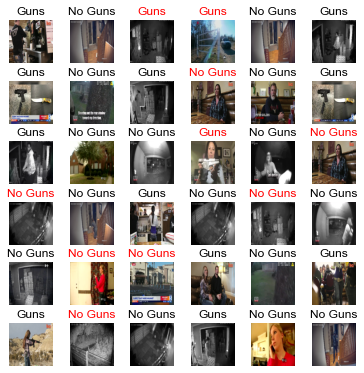

Set results:
------------------------------------------------
[[11  3]
 [ 7 15]]
kappa:        0.4444444444444444
accuracy:     0.7222222222222222
recall:       [0.78571429 0.68181818]
precision:    [0.61111111 0.83333333]
f_1:          [0.6875 0.75  ]


In [76]:
# Product list of samples
from math import sqrt

for images, labels in val_ds.take(10):
    fig_calc = int(sqrt(len(images)))
    fig = plt.figure(figsize=(fig_calc, fig_calc))
    label_pred = model.predict(images)
    for i in range(fig_calc * fig_calc):
        ax = fig.add_subplot(fig_calc, fig_calc, i + 1)
        plt.imshow(((np.clip(images[i].numpy(), -1, 1) + 1)/2).astype(np.float32))
        ax.set_title(class_names[labels[i]], fontsize=12, color = "black" if labels[i] == np.argmax(label_pred[i]) else "red")
        plt.axis("off")
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()
    print_results(labels, np.argmax(label_pred, axis=1))


Analyzing batch 0


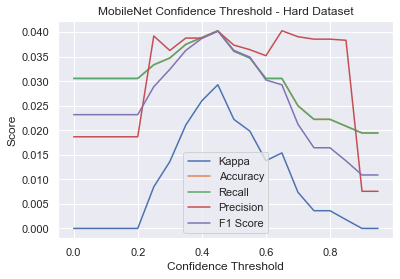

In [75]:
# For a batch, find the best confidence threshold.

x_points = np.arange(0, 1, 0.05)
y_point1 = np.zeros(len(x_points))
y_point2 = np.zeros(len(x_points))
y_point3 = np.zeros(len(x_points))
y_point4 = np.zeros(len(x_points))
y_point5 = np.zeros(len(x_points))
batch = 0
for images, labels in val_ds.take(300):
    print(F"Analyzing batch {batch}")
    label_pred = model.predict(images)
    x_point = 0
    for thresh in x_points:
        y_point1[x_point] += (metrics.cohen_kappa_score(labels, [i[1] > thresh for i in label_pred])) / len(x_points)
        y_point2[x_point] += (metrics.accuracy_score(labels, [i[1] > thresh for i in label_pred])) / len(x_points)
        y_point3[x_point] += (metrics.recall_score(labels, [i[1] > thresh for i in label_pred], average='weighted')) / len(x_points)
        y_point4[x_point] += (metrics.precision_score(labels, [i[1] > thresh for i in label_pred], average='weighted', zero_division=0)) / len(x_points)
        y_point5[x_point] += (metrics.f1_score(labels, [i[1] > thresh for i in label_pred], average='weighted')) / len(x_points)
        x_point += 1
    batch += 1

fig, ax = plt.subplots()
plot_1, = plt.plot(x_points, y_point1, label = "Kappa")
plot_2, = plt.plot(x_points, y_point2, label = "Accuracy")
plot_3, = plt.plot(x_points, y_point3, label = "Recall")
plot_4, = plt.plot(x_points, y_point4, label = "Precision")
plot_5, = plt.plot(x_points, y_point5, label = "F1 Score")
ax.legend(handles=[plot_1, plot_2, plot_3, plot_4, plot_5])
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.title(F"{MODEL} Confidence Threshold{' - Hard Dataset' if HARD else ''}")

plt.savefig(F"{MODEL}_Info/{MODEL}_confthresh{'_hard' if HARD else ''}.png")

plt.show()

In [23]:
fh = open(F"{MODEL}_Info/{MODEL}-Summary.txt", "w")
model.summary(print_fn=lambda x: fh.write(x + '\n'))